In [2]:
import numpy as np
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import cPickle

# Score-combinations for Kappa

In [158]:
base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/kappa_experiments/heldout_score_combination/"
eers_dir = base_dir + "score_combination/score_single_phonemes/"
features_combination_dir = base_dir + "features_combination/single/"
output_dir = "/Users/lmatayoshi/Desktop/mail_bootstrapping/"
output_dir_features_combination = output_dir + "features_combination/"
output_dir_score_combination = output_dir + "score_combination/"

In [4]:
kappa_phonemes = ['G', 'b', 'w', 'B', 'D', 'm', 'i', 's']

In [5]:
def load_heldout_speakers():
	speakers_filename = base_dir + "heldout_speakers"
	with open(speakers_filename, "r") as f:
		speakers = [line.rstrip() for line in f.readlines()]
	return speakers

In [6]:
def all_phonemes_empty_dict(phonemes):
    return dict(zip(phonemes, [[] for p in phonemes]))

In [7]:
def kappa_positives_negatives_dict():
    phonemes = ['G', 'b', 'w', 'B', 'D', 'm', 'i', 's']
    total_values = [865, 923, 1243, 1597, 2929, 3920, 6167, 8035]
    total_dict = dict(zip(phonemes, total_values))
    positives_values = [222, 528, 743, 428, 920, 3234, 4929, 7555]
    positives_dict = dict(zip(phonemes, positives_values))
    negatives_values = [643, 395, 500, 1169, 2009, 686, 1238, 480]
    negatives_dict = dict(zip(phonemes, negatives_values))
    return (total_dict, positives_dict, negatives_dict)

In [8]:
def check_logids(lines_supervectors, lines_second_source):
    logids_supervectors = [l[0] for l in lines_supervectors]
    logids_second_source = [l[0] for l in lines_second_source]
    if not logids_supervectors == logids_second_source:
        raise Exception(phoneme + " logids doesn't match in supervectors vs second source")
    

In [9]:
def label_for(label):
    if label == "True":
        return 1
    elif label == "False":
        return -1

In [10]:
def compute_EER(tuples):
    labels = [t[1] for t in tuples]
    hyperplane_distances = [t[0] for t in tuples]
    fpr, tpr, _ = roc_curve(labels, hyperplane_distances)
    # eer is where fpr is equal to fnr
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [11]:
def lines_for_speaker(lines, speaker):
    return [line for line in lines if speaker in line[0]]

In [12]:
def generate_shuffled_speakers_list(speakers, n):
    res = []
    for i in range(n):
        res.append(shuffled_with_replacement(speakers))
    return res

In [13]:
def shuffled_with_replacement(speakers):
	n_speakers = len(speakers)
	shuffled_indexes_with_replacement = np.random.randint(n_speakers, size=n_speakers)
	return [speakers[j] for j in shuffled_indexes_with_replacement]

Estrategia: 2 experimentos de score combination. Uno para supervectors_legendre y otro para supervectors_dct.
Para cada fonema, combino scores de ambos tips de features utilizando como factor el diccionario pasado por parámetro.
Modificar la lista original agregando a las tuplas los de cada speaker, una vez que genero los phoneme values

In [14]:
def main(eers_dir, second_source, proportion_dict):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(kappa_phonemes)
    supervectors_dir = eers_dir + "supervectors/"
    second_source_dir = eers_dir + second_source + "/"
    for phoneme in kappa_phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        second_source_filename = second_source_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        with open(second_source_filename, "r") as f_second_source:
            lines_second_source = f_second_source.readlines()
            lines_second_source = [l.split(" ") for l in lines_second_source]
        check_logids(lines_supervectors, lines_second_source)
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            new_lines_second_source = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
                new_lines_second_source = new_lines_second_source + lines_for_speaker(lines_second_source, speaker)
            check_logids(new_lines_supervectors, new_lines_second_source)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) + proportion_dict[original_phoneme]*float(new_lines_second_source[i][4])
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [67]:
def main_single_source(eers_dir, features_combination_type):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(kappa_phonemes)
    supervectors_dir = eers_dir + features_combination_type + "/"
    for phoneme in kappa_phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) 
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [16]:
proportion_legendre_dict = {
    'G': 0.0,
    'b': 0.0,
    'w': 0.0,
    'B': 0.5,
    'D': 0.0,
    'm': 0.4,
    'i': 0.4,
    's': 0.6
}

In [17]:
proportion_dct_dict = {
    'G': 0.0,
    'b': 0.0,
    'w': 0.0,
    'B': 0.3,
    'D': 0.0,
    'm': 0.6,
    'i': 0.3,
    's': 0.9
}

In [22]:
pickle_dir = base_dir + "pickles/"

In [23]:
with open(pickle_dir + "supervectors_legendre", "rb") as f:
    supervectors_legendre = cPickle.load(f)

In [24]:
with open(pickle_dir + "supervectors_dct", "rb") as f:
    supervectors_dct = cPickle.load(f)

In [25]:
with open(pickle_dir + "supervectors", "rb") as f:
    supervectors = cPickle.load(f)

In [18]:
#supervectors_legendre = main(eers_dir, "legendre", proportion_legendre_dict)

In [168]:
#supervectors_dct = main(eers_dir, "dct", proportion_dct_dict)

In [169]:
#supervectors = main_single_source(eers_dir)

# Features combination

In [68]:
features_combination_supervectors_legendre = main_single_source(features_combination_dir, "supervectors_legendre")

In [178]:
features_combination_supervectors_legendre_2 = main_single_source(features_combination_dir, "supervectors_legendre_2")

In [76]:
features_combination_supervectors_dct = main_single_source(features_combination_dir, "supervectors_dct")

# Results analysis

In [170]:
print "Supervectors: " + str(np.mean(supervectors['s']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['s']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['s']))

Supervectors: 0.258533856164
Supervectors + Legendre: 0.237377187782
Supervectors + DCT: 0.228542360614


In [171]:
print "Supervectors: " + str(np.mean(supervectors['i']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['i']))
print "Supervectors + DCt: " + str(np.mean(supervectors_dct['i']))

Supervectors: 0.255763078745
Supervectors + Legendre: 0.254031135465
Supervectors + DCt: 0.250416029842


In [172]:
print "Supervectors: " + str(np.mean(supervectors['m']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['m']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['m']))

Supervectors: 0.184052312052
Supervectors + Legendre: 0.173276135613
Supervectors + DCT: 0.170079267582


In [173]:
print "Supervectors: " + str(np.mean(supervectors['B']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['B']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['B']))

Supervectors: 0.177399912257
Supervectors + Legendre: 0.183571212935
Supervectors + DCT: 0.182987681966


In [174]:
print "Supervectors: " + str(np.mean(supervectors['G']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['G']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['G']))

Supervectors: 0.154825671213
Supervectors + Legendre: 0.155221411341
Supervectors + DCT: 0.154335038574


In [175]:
print "Supervectors: " + str(np.mean(supervectors['b']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['b']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['b']))

Supervectors: 0.124628200502
Supervectors + Legendre: 0.124267506438
Supervectors + DCT: 0.124906982651


In [176]:
print "Supervectors: " + str(np.mean(supervectors['w']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['w']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['w']))

Supervectors: 0.140882271001
Supervectors + Legendre: 0.138481630401
Supervectors + DCT: 0.139978370073


In [177]:
print "Supervectors: " + str(np.mean(supervectors['D']))
print "Supervectors + Legendre: " + str(np.mean(supervectors_legendre['D']))
print "Supervectors + DCT: " + str(np.mean(supervectors_dct['D']))

Supervectors: 0.184732972555
Supervectors + Legendre: 0.184749998091
Supervectors + DCT: 0.185409994209


In [116]:
def text_for_delta(number):
    if number < 0:
        return "improvement"
    else:
        return "degradation"

# Histograms

In [179]:
def plot_and_save_histogram(supervectors, score_combination, label, phoneme, output_dir=None):
    n_bins = 30
    #counts_positives_negatives, bins_positives_negatives, patches_positives_negatives = plt.hist(positives_negatives_distances, n_bins)
    counts_both, bins_both, _ = plt.hist(supervectors + score_combination, n_bins)

    ################
    # SUPERVECTORS # 
    ################

    n_supervectors, bins_supervectors, _ = plt.hist(supervectors, bins=bins_both)
    plt.clf()
    #normalized_positives = n_positives/total_positives

    #####################
    # SCORE COMBINATION #
    #####################

    n_score_combination, bins_score_combination, _ = plt.hist(score_combination, bins=bins_both)
    #normalized_negatives = n_negatives/total_negatives

    fixed_bins = []
    for i in range(0, len(bins_both) - 1):
        mean = (bins_both[i] + bins_both[i+1]) / 2
        fixed_bins.append(mean)

    plt.clf()
    
    supervectors_mean = np.mean(supervectors)
    combination_mean = np.mean(score_combination)
    delta = (combination_mean - supervectors_mean) / supervectors_mean
    delta_text = "%.2f" % np.abs(delta) + "% " + text_for_delta(delta)
    plt.title("Phoneme: " + phoneme + ", " + delta_text )
    plt.plot(fixed_bins, n_supervectors, color="blue", label="supervectors")   
    plt.plot(fixed_bins, n_score_combination, color="red", label= label)
    plt.axvline(x=supervectors_mean, linestyle="--", linewidth=0.5, color="blue")
    plt.axvline(x=combination_mean, linestyle="--", linewidth=0.5, color="red")
    plt.legend()
    plt.xticks(fixed_bins, rotation='vertical')
    plt.tight_layout()
    plt.xlabel("EER")
    plt.ylabel("count")
    if output_dir:
        plt.savefig(output_dir + phoneme)
    plt.show()


# Score combination

## Histograms Legendre

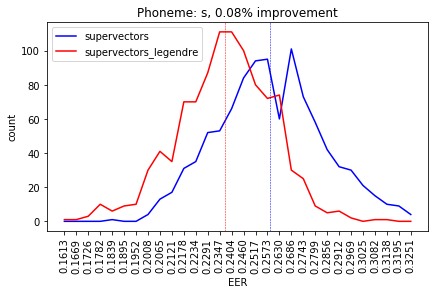

In [160]:
supervectors_s = supervectors['s']
supervectors_legendre_s = supervectors_legendre['s']
plot_and_save_histogram(supervectors_s, supervectors_legendre_s, "supervectors_legendre", 's', output_dir_score_combination + "supervectors_legendre/")

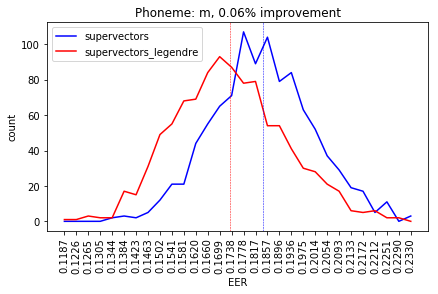

In [161]:
supervectors_m = supervectors['m']
supervectors_legendre_m = supervectors_legendre['m']
plot_and_save_histogram(supervectors_m, supervectors_legendre_m, "supervectors_legendre", 'm', output_dir_score_combination + "supervectors_legendre/")

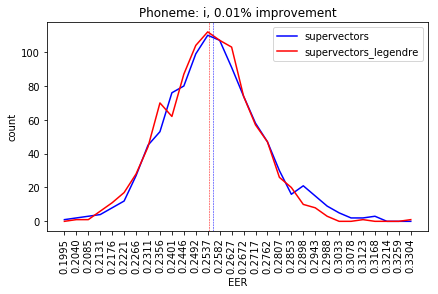

In [162]:
supervectors_i = supervectors['i']
supervectors_legendre_i = supervectors_legendre['i']
plot_and_save_histogram(supervectors_i, supervectors_legendre_i, "supervectors_legendre", 'i', output_dir_score_combination + "supervectors_legendre/")

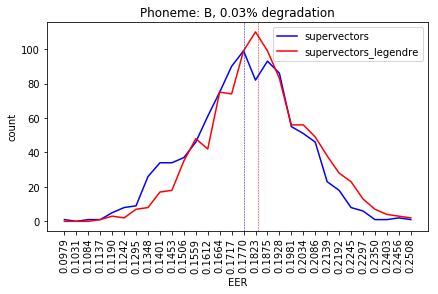

In [170]:
plot_and_save_histogram(supervectors['B'], supervectors_legendre['B'], "supervectors_legendre", 'B', output_dir_score_combination + "supervectors_legendre/")

## Histograms DCT

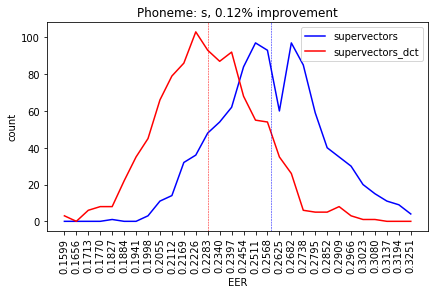

In [163]:
plot_and_save_histogram(supervectors['s'], supervectors_dct['s'], "supervectors_dct", 's', output_dir_score_combination + "supervectors_dct/")

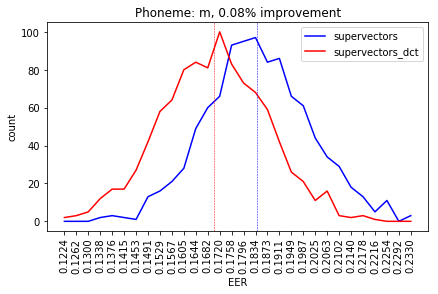

In [164]:
plot_and_save_histogram(supervectors['m'], supervectors_dct['m'], "supervectors_dct", 'm', output_dir_score_combination + "supervectors_dct/")

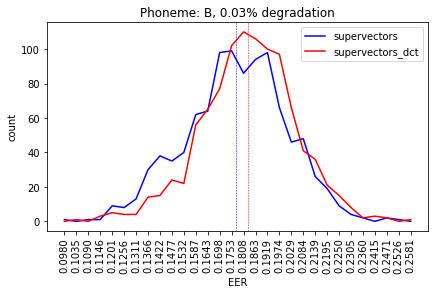

In [165]:
plot_and_save_histogram(supervectors['B'], supervectors_dct['B'], "supervectors_dct", 'B', output_dir_score_combination + "supervectors_dct/")

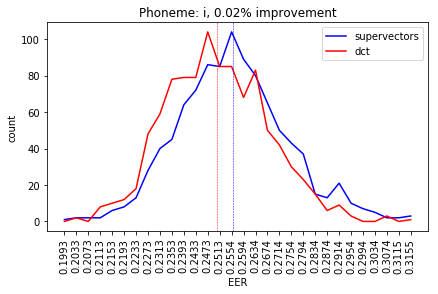

In [171]:
plot_and_save_histogram(supervectors['i'], supervectors_dct['i'], "dct", 'i', output_dir_score_combination + "supervectors_dct/")

# Features combination 

## Legendre

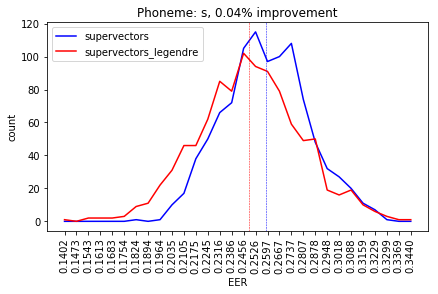

In [167]:
plot_and_save_histogram(supervectors['s'], features_combination_supervectors_legendre['s'], "supervectors_legendre", 's', output_dir_features_combination + "supervectors_legendre/")

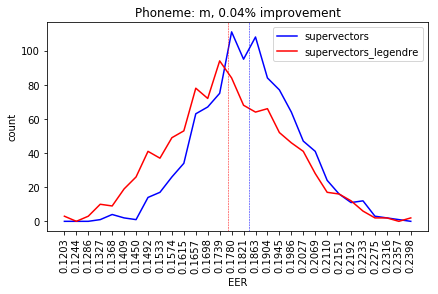

In [168]:
plot_and_save_histogram(supervectors['m'], features_combination_supervectors_legendre['m'], "supervectors_legendre", 'm', output_dir_features_combination + "supervectors_legendre/")

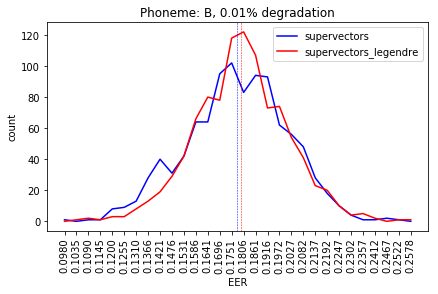

In [169]:
plot_and_save_histogram(supervectors['B'], features_combination_supervectors_legendre['B'], "supervectors_legendre", 'B', output_dir_features_combination + "supervectors_legendre/")

## DCT

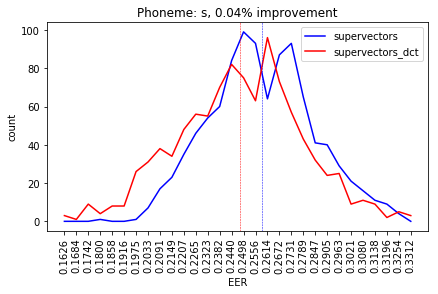

In [173]:
plot_and_save_histogram(supervectors['s'], features_combination_supervectors_dct['s'], "supervectors_dct", 's', output_dir_features_combination + "supervectors_dct/") 
                

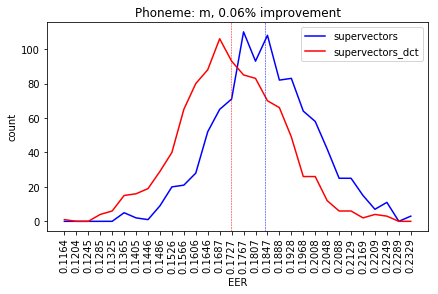

In [174]:
plot_and_save_histogram(supervectors['m'], features_combination_supervectors_dct['m'], "supervectors_dct", 'm', output_dir_features_combination + "supervectors_dct/")

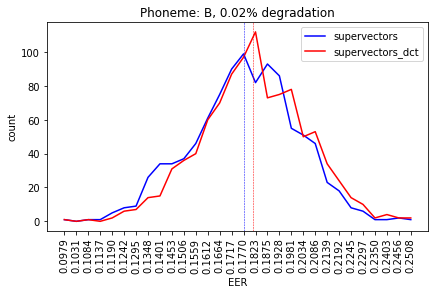

In [175]:
plot_and_save_histogram(supervectors['B'], features_combination_supervectors_dct['B'], "supervectors_dct", 'B', output_dir_features_combination + "supervectors_dct/")

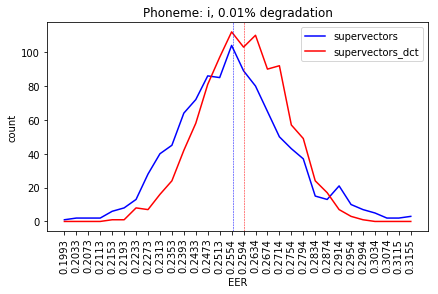

In [177]:
plot_and_save_histogram(supervectors['i'], features_combination_supervectors_dct['i'], "supervectors_dct", 'i', output_dir_features_combination + "supervectors_dct/")

## Other phonemes

## Score combination

## Legendre

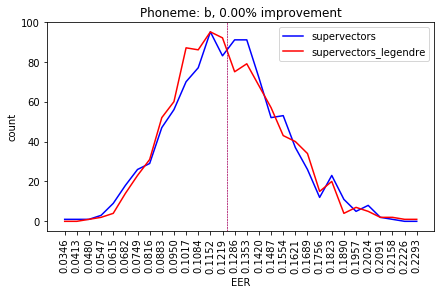

In [140]:
plot_and_save_histogram(supervectors['b'], supervectors_legendre['b'], "supervectors_legendre", 'b')

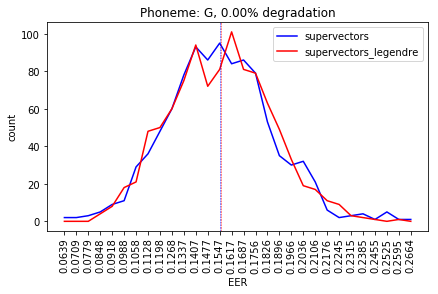

In [139]:
plot_and_save_histogram(supervectors['G'], supervectors_legendre['G'], "supervectors_legendre", 'G')

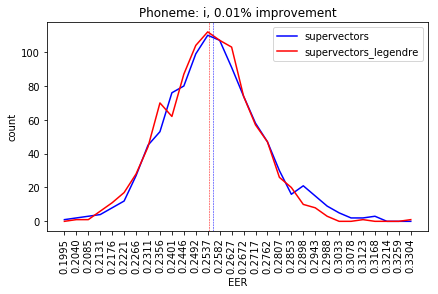

In [141]:
plot_and_save_histogram(supervectors['i'], supervectors_legendre['i'], "supervectors_legendre", 'i')

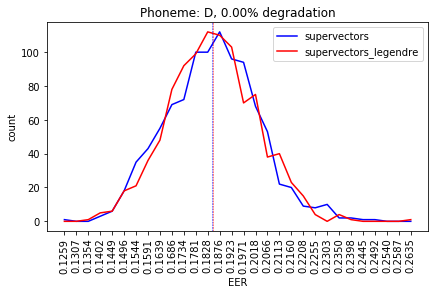

In [142]:
plot_and_save_histogram(supervectors['D'], supervectors_legendre['D'], "supervectors + legendre", 'D')

## DCT

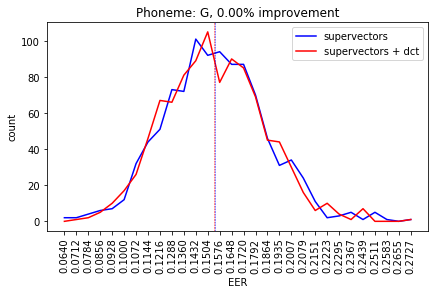

In [143]:
plot_and_save_histogram(supervectors['G'], supervectors_dct['G'], "supervectors + dct", 'G')

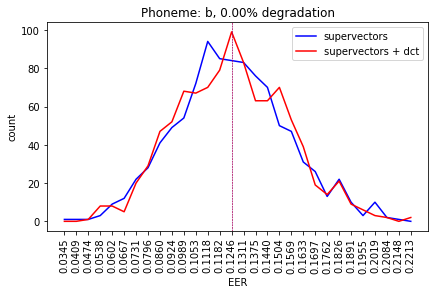

In [144]:
plot_and_save_histogram(supervectors['b'], supervectors_dct['b'], "supervectors + dct", 'b')

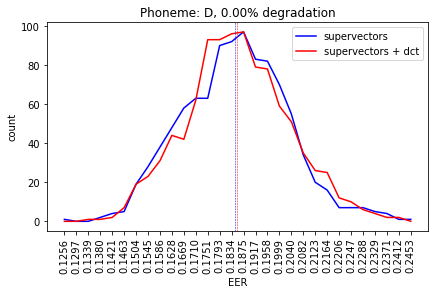

In [145]:
plot_and_save_histogram(supervectors['D'], supervectors_dct['D'], "supervectors + dct", 'D')

## Features combination

## Legendre

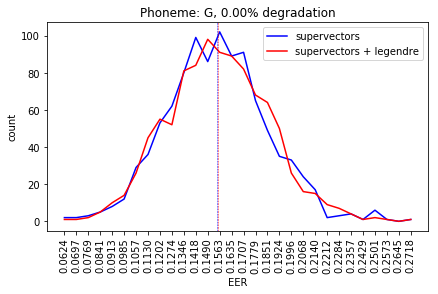

In [146]:
plot_and_save_histogram(supervectors['G'], features_combination_supervectors_legendre['G'], "supervectors + legendre", 'G')

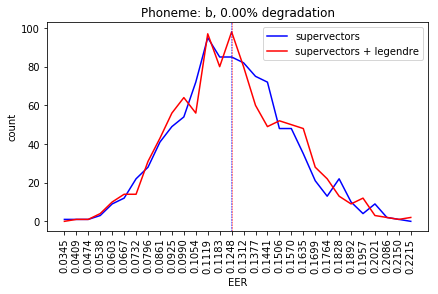

In [147]:
plot_and_save_histogram(supervectors['b'], features_combination_supervectors_legendre['b'], "supervectors + legendre", 'b')

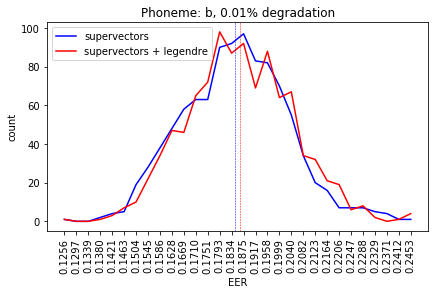

In [148]:
plot_and_save_histogram(supervectors['D'], features_combination_supervectors_legendre['D'], "supervectors + legendre", 'b')

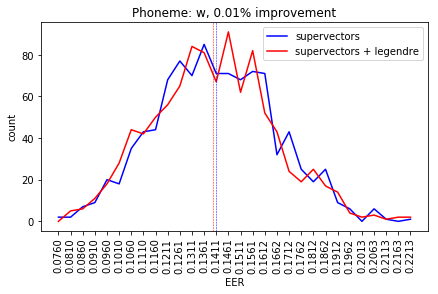

In [150]:
plot_and_save_histogram(supervectors['w'], features_combination_supervectors_legendre['w'], "supervectors + legendre", 'w')

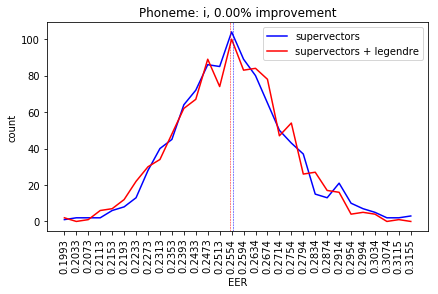

In [149]:
plot_and_save_histogram(supervectors['i'], features_combination_supervectors_legendre['i'], "supervectors + legendre", 'i')

## DCT

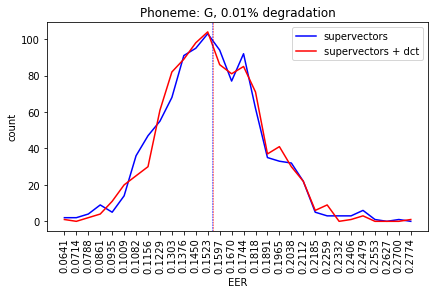

In [151]:
plot_and_save_histogram(supervectors['G'], features_combination_supervectors_dct['G'], "supervectors + dct", 'G')

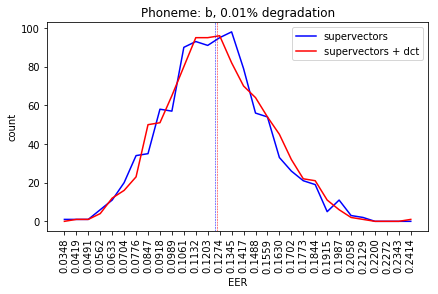

In [152]:
plot_and_save_histogram(supervectors['b'], features_combination_supervectors_dct['b'], "supervectors + dct", 'b')

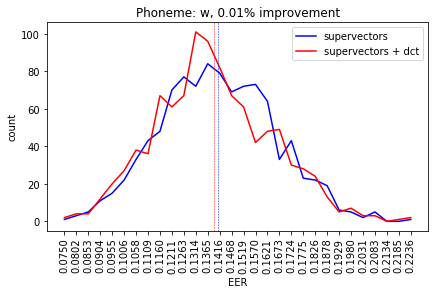

In [153]:
plot_and_save_histogram(supervectors['w'], features_combination_supervectors_dct['w'], "supervectors + dct", 'w')

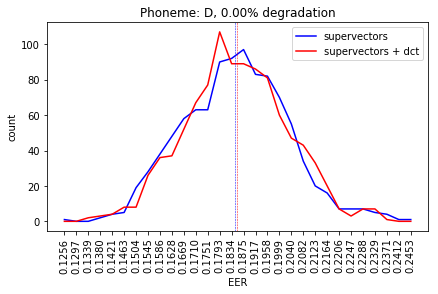

In [154]:
plot_and_save_histogram(supervectors['D'], features_combination_supervectors_dct['D'], "supervectors + dct", 'D')

# Sanity checks features combination

## Sanity check supervectors_legendre

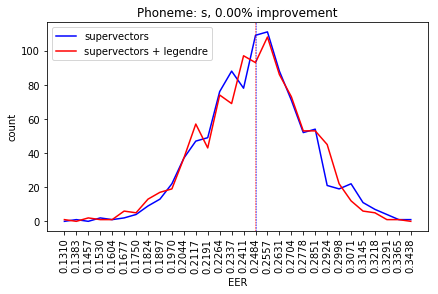

In [180]:
plot_and_save_histogram(features_combination_supervectors_legendre['s'], features_combination_supervectors_legendre_2['s'], "supervectors + legendre", 's')

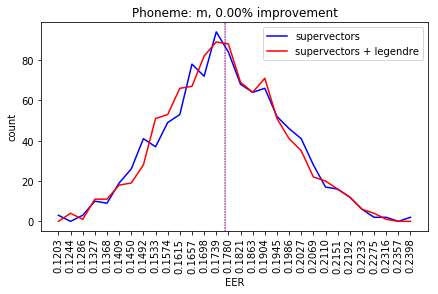

In [182]:
plot_and_save_histogram(features_combination_supervectors_legendre['m'], features_combination_supervectors_legendre_2['m'], "supervectors + legendre", 'm')

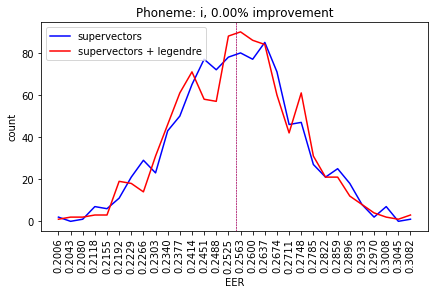

In [183]:
plot_and_save_histogram(features_combination_supervectors_legendre['i'], features_combination_supervectors_legendre_2['i'], "supervectors + legendre", 'i')

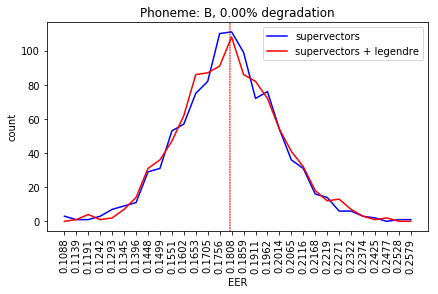

In [186]:
plot_and_save_histogram(features_combination_supervectors_legendre['B'], features_combination_supervectors_legendre_2['B'], "supervectors + legendre", 'B')

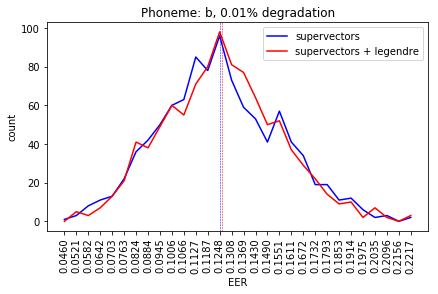

In [185]:
plot_and_save_histogram(features_combination_supervectors_legendre['b'], features_combination_supervectors_legendre_2['b'], "supervectors + legendre", 'b')

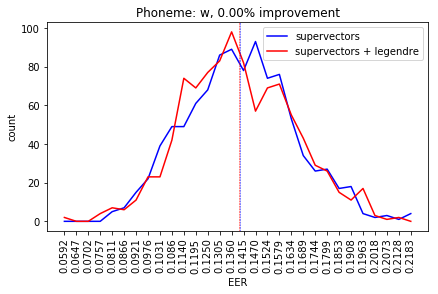

In [187]:
plot_and_save_histogram(features_combination_supervectors_legendre['w'], features_combination_supervectors_legendre_2['w'], "supervectors + legendre", 'w')

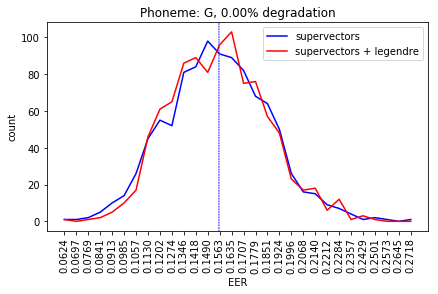

In [188]:
plot_and_save_histogram(features_combination_supervectors_legendre['G'], features_combination_supervectors_legendre_2['G'], "supervectors + legendre", 'G')

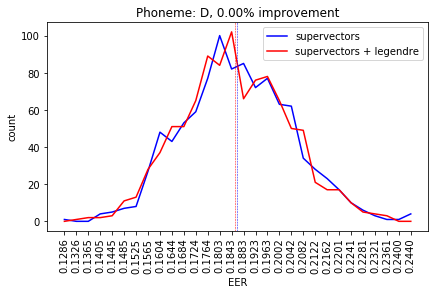

In [189]:
plot_and_save_histogram(features_combination_supervectors_legendre['D'], features_combination_supervectors_legendre_2['D'], "supervectors + legendre", 'D')

In [48]:
def main_sanity_checks(sanity_checks_single_type_dir):
    ### Dictionary generation 
    res = all_phonemes_empty_dict(kappa_phonemes)
    for phoneme in kappa_phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = sanity_checks_single_type_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            values = [float(l.strip().split(":")[1]) for l in lines_supervectors]
            res[original_phoneme] = values
    return res

In [49]:
sanity_checks_dir = base_dir + "sanity_checks/single/"

In [51]:
supervectors_sanity_check = main_sanity_checks(sanity_checks_dir + "supervectors/")

## Sanity check supervectors

In [59]:
print "Phoneme s"
print "Supervectors: " + str(np.mean(supervectors['s']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['s']))

print "\n"

print "Phoneme m"
print "Supervectors: " + str(np.mean(supervectors['m']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['m']))

print "\n"

print "Phoneme i"
print "Supervectors: " + str(np.mean(supervectors['i']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['i']))

print "\n"

print "Phoneme B"
print "Supervectors: " + str(np.mean(supervectors['B']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['B']))

print "\n"

print "Phoneme G"
print "Supervectors: " + str(np.mean(supervectors['G']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['G']))

print "\n"

print "Phoneme b"
print "Supervectors: " + str(np.mean(supervectors['b']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['b']))

print "\n"

print "Phoneme D"
print "Supervectors: " + str(np.mean(supervectors['D']))
print "Supervectors sanity check: " + str(np.mean(supervectors_sanity_check['D']))

Phoneme s
Supervectors: 0.258533856164
Supervectors sanity check: 0.259123828811


Phoneme m
Supervectors: 0.184052312052
Supervectors sanity check: 0.184147131327


Phoneme i
Supervectors: 0.255763078745
Supervectors sanity check: 0.255654219424


Phoneme B
Supervectors: 0.177399912257
Supervectors sanity check: 0.177095592872


Phoneme G
Supervectors: 0.154825671213
Supervectors sanity check: 0.151360266956


Phoneme b
Supervectors: 0.124628200502
Supervectors sanity check: 0.12602050038


Phoneme D
Supervectors: 0.184732972555
Supervectors sanity check: 0.182132587261
